
=== Feature Rationales ===
1) vol_1h_std: Std dev of 5-min returns over last 12 bars (~1h).
   Why: Captures recent volatility clustering; useful for forecasting near-term volatility.
2) log_hl_range: log(high/low) per bar.
   Why: Range-based volatility proxy; larger intrabar ranges imply higher risk/variance.
3) vol_z_1d: Rolling 1-day (288 bars) z-score of volume.
   Why: Abnormal volume often coincides with outsized moves; normalization handles regime shifts.
4) mom_1h_mean: Mean of returns over last 12 bars (~1h).
   Why: Short-horizon momentum/mean-reversion effects relate to microstructure and flows.

=== Pearson Correlation with Target (next |return|) ===
target_next_abs_ret    1.000000
vol_1h_std             0.496845
log_hl_range           0.492071
vol_z_1d               0.207897
mom_1h_mean           -0.082682
Name: target_next_abs_ret, dtype: float64


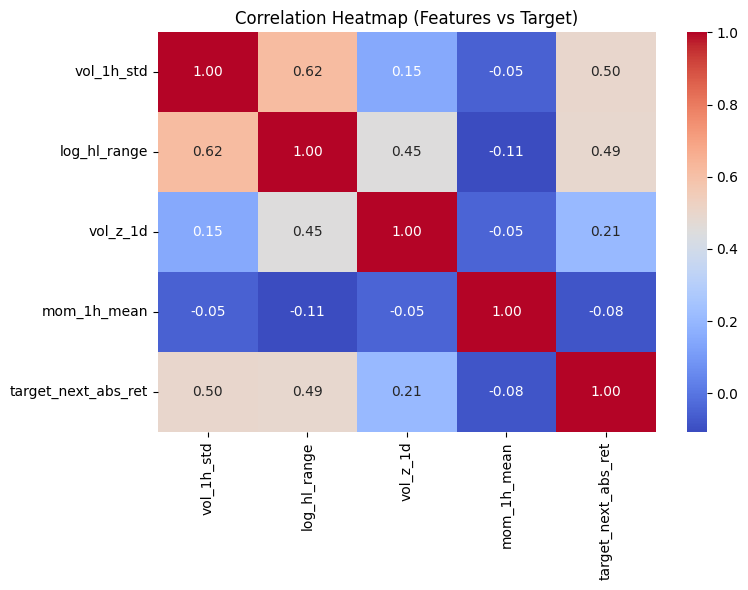

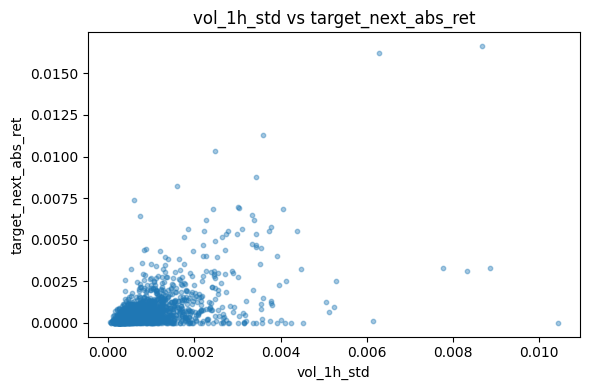

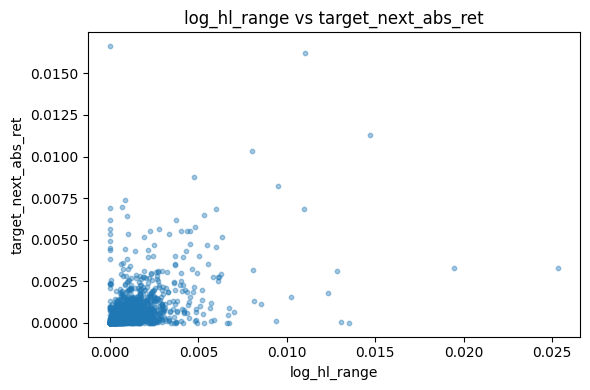

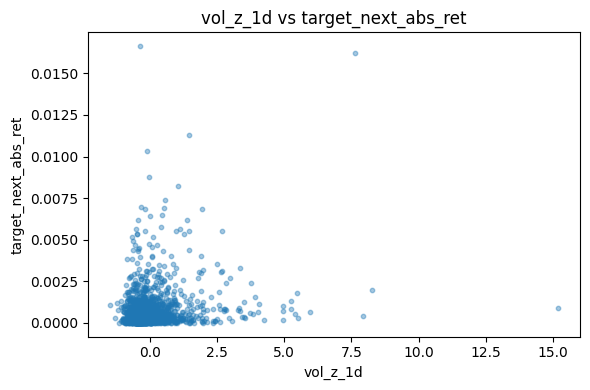

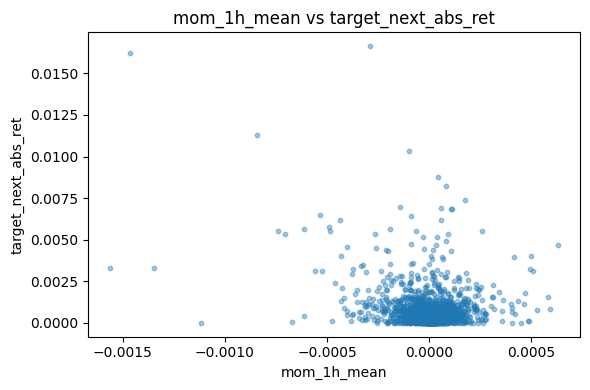

C:\Users\arnav\AppData\Local\Temp\ipykernel_52108\4175464750.py:107: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\arnav\anaconda3\envs\bootcamp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arnav\anaconda3\envs\bootcamp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\arnav\anaconda3\envs\bootcamp_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


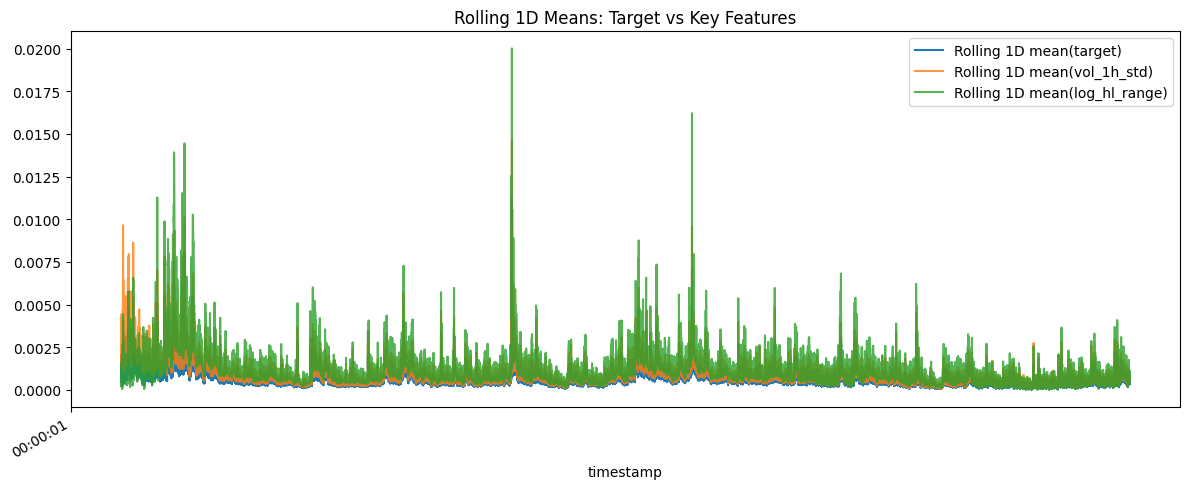


Saved engineered dataset → btc_features.parquet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# CONFIG
INPUT_PATH = "OHLCV_Binance_BTC-USDT_D20170817T040000UTC-D20240404T115959UTC_1min.csv"   
SAVE_FEATURES_TO = "btc_features.parquet"  
TIME_COL = "timestamp"


def load_btc(path):
    df = pd.read_csv(path)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    df.set_index(TIME_COL, inplace=True, drop=False)
    required = {"open","high","low","close","volume", TIME_COL}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    return df


def engineer_features(df):
    out = df.copy()

    # Log returns
    out["ret"] = np.log(out["close"]).diff()

    # New Feature 1: Rolling 1h Volatility (std of 1-min returns over last 60 bars)
    # Rationale: Short-horizon volatility clusters; recent realized volatility helps forecast near-term volatility.
    out["vol_1h_std"] = out["ret"].rolling(window=60, min_periods=60).std()

    # New Feature 2: High-Low Log Range (per-bar)
    # Rationale: Range-based estimators (e.g., Parkinson) are efficient volatility proxies; larger ranges imply higher risk.
    out["log_hl_range"] = np.log(out["high"] / out["low"]).replace([np.inf, -np.inf], np.nan)

    # New Feature 3: Volume Z-score 
    # Rationale: Abnormal volume often occurs with large price moves; z-score normalizes across the shifts.
    out["vol_z_1d"] = (out["volume"] - out["volume"].rolling(1440, min_periods=120).mean()) \
                        / out["volume"].rolling(1440, min_periods=120).std()

    # New Feature 4: 1h Return Momentum (mean of last 60 returns)
    # Rationale: Short-term serial dependence / microstructure effects can create momentum/mean-reversion signals.
    out["mom_1h_mean"] = out["ret"].rolling(window=60, min_periods=60).mean()

    # Target: next-bar absolute return (near-term volatility proxy)
    out["target_next_abs_ret"] = out["ret"].shift(-1).abs()

    # Clean up
    features = ["vol_1h_std", "log_hl_range", "vol_z_1d", "mom_1h_mean", "target_next_abs_ret"]
    out = out.dropna(subset=features).copy()
    return out, features

def print_feature_rationales():
    print("\n=== Feature Rationales ===")
    print("1) vol_1h_std: Std dev of 5-min returns over last 12 bars (~1h).")
    print("   Why: Captures recent volatility clustering; useful for forecasting near-term volatility.")
    print("2) log_hl_range: log(high/low) per bar.")
    print("   Why: Range-based volatility proxy; larger intrabar ranges imply higher risk/variance.")
    print("3) vol_z_1d: Rolling 1-day (288 bars) z-score of volume.")
    print("   Why: Abnormal volume often coincides with outsized moves; normalization handles regime shifts.")
    print("4) mom_1h_mean: Mean of returns over last 12 bars (~1h).")
    print("   Why: Short-horizon momentum/mean-reversion effects relate to microstructure and flows.\n")


def correlation_tests(df_feat, features, target="target_next_abs_ret"):
    cols = [c for c in features if c != target]
    corr = df_feat[cols + [target]].corr()[target].sort_values(ascending=False)
    print("=== Pearson Correlation with Target (next |return|) ===")
    print(corr)
    return corr

def make_plots(df_feat, features, target="target_next_abs_ret", sample=2000):
    cols = [c for c in features if c != target]

    # Heatmap
    plt.figure(figsize=(8,6))
    corr_mat = df_feat[cols + [target]].corr()
    sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap (Features vs Target)")
    plt.tight_layout()
    plt.show()

    # Scatter plots vs target (sampled to avoid overplotting)
    plot_df = df_feat.sample(min(sample, len(df_feat)), random_state=42)
    for c in cols:
        plt.figure(figsize=(6,4))
        plt.scatter(plot_df[c], plot_df[target], alpha=0.4, s=10)
        plt.xlabel(c)
        plt.ylabel(target)
        plt.title(f"{c} vs {target}")
        plt.tight_layout()
        plt.show()

    # Optional: simple rolling comparison plot
    plt.figure(figsize=(12,5))
    df_feat[target].rolling(288).mean().plot(label="Rolling 1D mean(target)")
    for c in ["vol_1h_std","log_hl_range"]:
        if c in df_feat.columns:
            df_feat[c].rolling(288).mean().plot(label=f"Rolling 1D mean({c})", alpha=0.8)
    plt.legend()
    plt.title("Rolling 1D Means: Target vs Key Features")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    df = load_btc(INPUT_PATH)
    df_feat, features = engineer_features(df)

    print_feature_rationales()
    corr = correlation_tests(df_feat, features)

    make_plots(df_feat, features)

    if SAVE_FEATURES_TO is not None:
        Path(SAVE_FEATURES_TO).parent.mkdir(parents=True, exist_ok=True)
        df_feat.to_parquet(SAVE_FEATURES_TO, index=False)
        print(f"\nSaved engineered dataset → {SAVE_FEATURES_TO}")
